In [4]:
!pip install matplotlib

In [18]:
!pip install torchsummary

In [1]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)



Using Pytorch version :  1.10.0  Device :  cuda


### 1. 데이터  탐색
https://github.com/RadicalHealthTech/CV-Assignment/blob/master/DL_task.ipynb

참조

In [1]:
import os


good_path = "./data/DRIMDB/Good/"
good_list= os.listdir(good_path)
#이미지만 캐기
good_data_list = [  data for data in  good_list if data != 'drimdb_good']

good_data = []
for data in good_data_list:
    temp_img=cv2.imread(good_path+data)
    #이미지 사이즈 논문에 맞게 512 512
    temp_img=cv2.resize(temp_img,(512,512))
    temp_img=cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)#PLOT 출력위해
    good_data.append(temp_img)
print("good: ",len(good_data))

NameError: name 'cv2' is not defined

In [3]:
bad_path = "./data/DRIMDB/Bad/"
bad_list = os.listdir(bad_path)
bad_data_list = [  data for data in  bad_list if data != 'drimdb_bad']

bad_data = []
for data in bad_data_list:
    temp_img=cv2.imread(bad_path+data)
    #이미지 사이즈 논문에 맞게 512 512
    temp_img=cv2.resize(temp_img,(512,512))
    temp_img=cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)#PLOT 출력위해
    bad_data.append(temp_img)
print("bad: ",len(bad_data))


bad:  69


### good 이미지

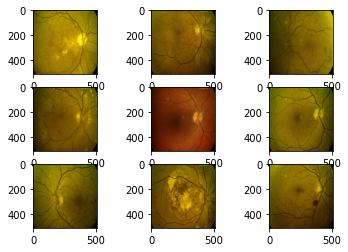

In [4]:
plt.figure(3)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(good_data[i])

### bad 이미지

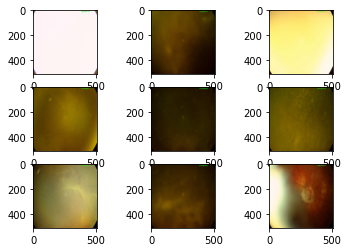

In [5]:
plt.figure(3)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(bad_data[i])

#### 캐니 에지 디텍션

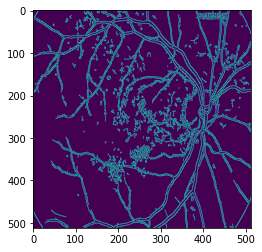

In [6]:
plt.imshow(cv2.Canny(good_data[0],50,100))

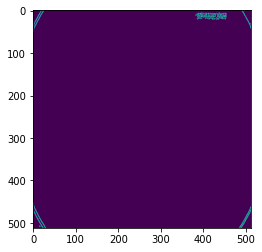

In [8]:
plt.imshow(cv2.Canny(bad_data[0],50,100))

In [4]:
del good_data
del bad_data

NameError: name 'bad_data' is not defined

## 2. 데이터 나누기 

In [2]:
#1. train, test 나누기
import os
import random #데이터 shuffle 사용
from glob import glob

GOOD_DATA_PATH_LIST = glob('./data/DRIMDB/Good/*.jpg')
BAD_DATA_PATH_LIST = glob('./data/DRIMDB/BAD/*.jpg')
print("GOOD : ",len(GOOD_DATA_PATH_LIST))
print("BAD: ",len(BAD_DATA_PATH_LIST))

X = GOOD_DATA_PATH_LIST+BAD_DATA_PATH_LIST
print(len(X))
Y = {}
for idx,x in enumerate(X):
    if idx<125:
        Y[x]="Good"
    else:
        Y[x]="Bad"

#train 124  : valid 31 : test 39
random.shuffle(X)
DATA_PATH_TRAINING_LIST = X[:124]
DATA_PATH_VALIDATION_LIST = X[124:155]
DATA_PATH_TEST_LIST = X[155:194]

print(DATA_PATH_TEST_LIST)

GOOD :  125
BAD:  69
194
['./data/DRIMDB/Good\\drimdb_good (38).jpg', './data/DRIMDB/Good\\drimdb_good (56).jpg', './data/DRIMDB/BAD\\drimdb_bad (29).jpg', './data/DRIMDB/Good\\drimdb_good (52).jpg', './data/DRIMDB/Good\\drimdb_good (64).jpg', './data/DRIMDB/Good\\drimdb_good (67).jpg', './data/DRIMDB/BAD\\drimdb_bad (11).jpg', './data/DRIMDB/Good\\drimdb_good (20).jpg', './data/DRIMDB/Good\\drimdb_good (111).jpg', './data/DRIMDB/Good\\drimdb_good (59).jpg', './data/DRIMDB/Good\\drimdb_good (68).jpg', './data/DRIMDB/BAD\\drimdb_bad (52).jpg', './data/DRIMDB/BAD\\drimdb_bad (53).jpg', './data/DRIMDB/Good\\drimdb_good (105).jpg', './data/DRIMDB/BAD\\drimdb_bad (12).jpg', './data/DRIMDB/Good\\drimdb_good (80).jpg', './data/DRIMDB/Good\\drimdb_good (73).jpg', './data/DRIMDB/BAD\\drimdb_bad (69).jpg', './data/DRIMDB/Good\\drimdb_good (116).jpg', './data/DRIMDB/BAD\\drimdb_bad (21).jpg', './data/DRIMDB/BAD\\drimdb_bad (65).jpg', './data/DRIMDB/Good\\drimdb_good (3).jpg', './data/DRIMDB/BAD\\

In [3]:
#2. 데이터 정의

from torch.utils.data import Dataset, DataLoader

classes = ["Good","Bad"]

class drimdb_dataset(Dataset):
    def __init__(self,data_path_list,classes,transform):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        self.path_list = data_path_list
        self.label = drimdb_dataset.get_label(data_path_list)
        self.classes=classes
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        for path in data_path_list:
            label_list.append(Y[path])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        학습에 사용할 이미지를 반환하면 된다. 이 함수는 인풋으로 index를 받는다. 
        path_list에서 index에 해당하는 이미지를 읽으면 된다. 
        이때 텐서형태의 인풋이 들어오기때문에 리스트로 변환하여준다.(굳이 안해도됨)
        반환값으로는 경로로부터 읽어들여 transform을 적용한 이미지 파일과 정답에 해당하는 클래스를 반환하면 된다.
        이때, 클래스를 숫자로 반환하여야 한다. 
        예를들면 Good: 0 Bad:1. 클래스 리스트의 index로 반환하게 구현하였다.
        """
        image = cv2.resize(cv2.imread(self.path_list[idx]),(512,512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ⑤ (Height, Width,Channel) → (Batch, Channel, Height, Width) 이렇게 바꿔줘야한다.
        image = torch.from_numpy(image).type(torch.float32)
        image = image.permute(2, 0, 1)
        return image, float(self.classes.index(self.label[idx]))
    

In [4]:
#2. 데이터 정의

from torch.utils.data import Dataset, DataLoader

classes = ["Good","Bad"]

class drimdb_dataset(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        self.path_list = data_path_list
        self.label = drimdb_dataset.get_label(data_path_list)
        self.classes=classes
        self.transform=transform
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        for path in data_path_list:
            label_list.append(Y[path])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        학습에 사용할 이미지를 반환하면 된다. 이 함수는 인풋으로 index를 받는다. 
        path_list에서 index에 해당하는 이미지를 읽으면 된다. 
        이때 텐서형태의 인풋이 들어오기때문에 리스트로 변환하여준다.(굳이 안해도됨)
        반환값으로는 경로로부터 읽어들여 transform을 적용한 이미지 파일과 정답에 해당하는 클래스를 반환하면 된다.
        이때, 클래스를 숫자로 반환하여야 한다. 
        예를들면 Good: 0 Bad:1. 클래스 리스트의 index로 반환하게 구현하였다.
        """
        image = cv2.resize(cv2.imread(self.path_list[idx]),(512,512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ⑤ (Height, Width,Channel) → (Batch, Channel, Height, Width) 이렇게 바꿔줘야한다.
        if self.transform:
            image=self.transform(image).type(torch.float32)
        else:
            image = torch.from_numpy(image).type(torch.float32)
            image = image.permute(2, 0, 1)
        return image, float(self.classes.index(self.label[idx]))
    

In [5]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 16개 이미지
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [6]:

#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = 
                                           drimdb_dataset(
                                               DATA_PATH_TRAINING_LIST,
                                               classes,
                                               transform = transforms.ToTensor()
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.


test_loader = torch.utils.data.DataLoader(dataset = 
                                           drimdb_dataset(
                                               DATA_PATH_TEST_LIST,
                                               classes,
                                               transform = transforms.ToTensor()
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.

#validation set 추가해야됨.
#https://bekusib.tistory.com/159
#이전 예제에서는 test를 중간 중간 실시했는데, 그러면 안됨.

X_train :  torch.Size([16, 3, 512, 512]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.DoubleTensor


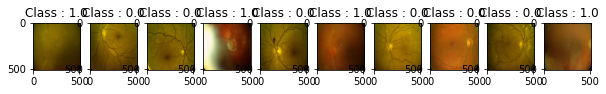

In [7]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

#배치 데이터한개
#X: 이미지. 32배치 사이즈. 3 rgb. 32x32 이미지.
#Y: 32개의 라벨



# 이미지 데이터확인
#np.transpose로 (채널,가로,세로) -> (세로,가로,채널) 이렇게 해야지 그릴 수 있다.
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))#하나당 10,1

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.transpose(X_train[i].detach().numpy(),(1,2,0)))# 배치에서 10개만 추출
    plt.title('Class : '+str(Y_train[i].item()))


## 3. 모델 설계
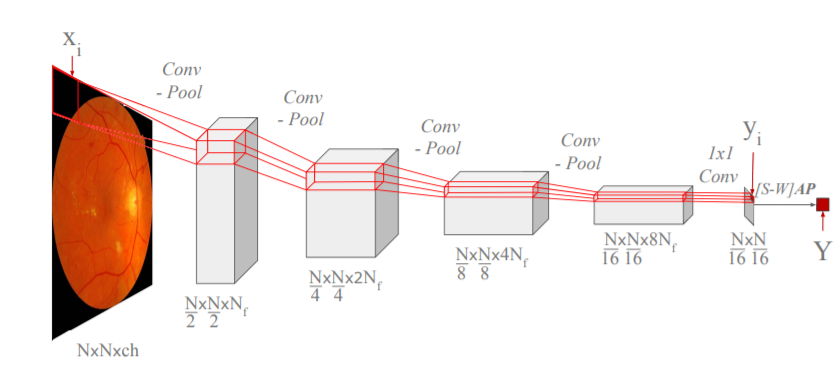

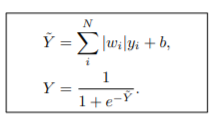

In [22]:
# 3x3 컨볼루션 4개
# 2x2 stride max pooling 4개
# 1x1 conv + sigmoid
# SWAP

#6 -3. CNN 모델
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        #컨볼루션 커널 정의 및 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels = 3,# RGB이자,이미지 두께가 몇개인지
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch1= nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(
            in_channels = 64,# featureMap 64개
            out_channels = 128,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch2= nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(
            in_channels = 128,# 
            out_channels = 256,#
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch3= nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(
            in_channels = 256,# 
            out_channels = 512,# 
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.batch4= nn.BatchNorm2d(512)
        
        #1x1 conv
        self.conv5 = nn.Conv2d(
            in_channels = 512,#
            out_channels = 1,# 
            kernel_size = 1,#1x1
        )
        
        #max pooling
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        #이미지의 크기가 4분의 1줄어든다.
        
        
        #SWAP
        #self.weighted=nn.Parameter(torch.empty((32, 32), requires_grad=True))
        self.weighted=nn.Parameter(torch.ones((32, 32), requires_grad=True))
        #nn.init.xavier_uniform_(self.weighted, gain=1.0)
        #nn.init.uniform_(self.weighted, a=0.0, b=1.0)
        #self.weighted= torch.abs(self.weighted)
        self.bias=nn.Parameter(torch.zeros(1, requires_grad=True))
        self.sigmoid2 = nn.Sigmoid()


    
    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool(x)
        

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)
        x = self.pool(x)
        

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)

        #SWAP 과정
        
        #print(x.size())
        x = torch.abs(self.weighted)/sum(torch.abs(self.weighted)) * x  # element-wise 곱
        #x = torch.abs(self.weighted) * x  # element-wise 곱
        #print('곱 결과: ',x.size())
        #print("sum of weight, bias",torch.sum(self.weighted).item(),self.bias.item())
        #print(x)
        x=torch.sum(x,dim=3)
        x=torch.sum(x,dim=2)# 내적 과정
        x=x.squeeze(1)
        x=torch.add(x,-0.5) # 저자는 0.5를 먼저 빼줌.
        x=torch.add(x,self.bias) #스칼라 add
        x=self.sigmoid2(x) # BCEWithLogitsLoss 으로 수정해서, sigmoid를 뺌.
        #print('model 결과: ',x.size())
        
        return x

In [8]:
# 3x3 컨볼루션 4개
# 2x2 stride max pooling 4개
# 1x1 conv + sigmoid
# average pooling


#6 -3. CNN 모델
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        #컨볼루션 커널 정의 및 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            in_channels = 3,# RGB이자,이미지 두께가 몇개인지
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.conv2 = nn.Conv2d(
            in_channels = 64,# featureMap 64개
            out_channels = 128,# FeatureMap 수,커널 수
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.conv3 = nn.Conv2d(
            in_channels = 128,# 
            out_channels = 256,#
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        self.conv4 = nn.Conv2d(
            in_channels = 256,# 
            out_channels = 512,# 
            kernel_size = 3,#3x3
            padding=1,#제로패딩.크기 유지
        )
        
        #1x1 conv
        self.conv5 = nn.Conv2d(
            in_channels = 512,#
            out_channels = 1,# 
            kernel_size = 1,#1x1
        )
        
        #max pooling
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        #이미지의 크기가 4분의 1줄어든다.
        #self.sigmoid1 = nn.Sigmoid()
        
        #average pooling
        #self.weighted=nn.Parameter(torch.empty((32, 32), requires_grad=True))
        #nn.init.xavier_uniform_(self.weighted, gain=1.0)
        #nn.init.uniform_(self.weighted, a=0.0, b=1.0)
        #self.weighted= torch.abs(self.weighted)
        #self.bias=nn.Parameter(torch.randn(1, requires_grad=True))
        self.avgpool = nn.AvgPool2d(kernel_size=32,stride=1)


    
    def forward(self,x):
        x = self.conv1(x)
        #x = F.relu(x)
        x = self.pool(x)
        

        x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        #x = F.relu(x)
        x = self.pool(x)
        

        x = self.conv4(x)
        #x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        #x = self.sigmoid1(x)# input이 여러개여도 배열로 출력되나?
        
        #SWAP 과정
        
        #x=torch.add(x,self.bias) #스칼라 add
        x=self.avgpool(x) # BCEWithLogitsLoss 으로 수정해서, sigmoid를 뺌.
        x=x.squeeze()
        #print('model 결과: ',x.size())
        
        return x

In [16]:
a=torch.scalar_tensor(-0.5)
b=torch.randn((16,1,4,4))
c=torch.randn((16,1,4,4))
d=torch.randn(4,4)
torch.dot(b,d)

#torch.sigmoid(torch.add(g.squeeze(1),a))


RuntimeError: 1D tensors expected, but got 4D and 2D tensors

In [23]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
criterion = nn.BCELoss()#logistic regression이기 때문에. binary cross entropy loss
print(model)
list(model.parameters())[:1]# SWAP 파라미터만 확인

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid2): Sigmoid()
)


[Parameter containing:
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)]

In [24]:
# 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    count=0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.type(torch.FloatTensor).to(DEVICE)
        #print(label.dtype)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        if count==0:
            print(output)
        
        #if count== 0:
        #    print(model.weighted)
        #print(output)
        #print(label)
        loss = criterion(output, label) #loss 계산
        #print(loss)
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
        count+=1

In [25]:
# 학습 진행하며, test 데이터로 모델 성능확인
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    threshold=torch.FloatTensor([0.5]).cuda()
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.type(torch.FloatTensor).to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output >= threshold
            
            #print(output.max(1,keepdim=True))
            #print(prediction)
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 16개라서.
            #true.false값을 sum해줌. item
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss,test_accuracy
            

In [26]:
#10. 학습 및 평가.
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval=200)
    test_loss,test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n, ".
          format(Epoch,test_loss,test_accuracy))

tensor([3.5756e-05, 5.9703e-04, 2.6183e-06, 1.8124e-05, 1.4635e-11, 8.8783e-10,
        5.6742e-05, 1.5134e-05, 5.6743e-17, 5.8501e-08, 1.8992e-08, 1.7701e-04,
        4.6213e-04, 1.6018e-15, 3.9352e-06, 4.2150e-06], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:1], 	Test Loss:0.1822 	Test Accuracy: 38.46 %
, 
tensor([1.0000e+00, 1.5886e-08, 2.5542e-20, 1.8949e-11, 4.9640e-12, 1.0000e+00,
        1.0000e+00, 7.3340e-12, 1.6799e-16, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0448e-31, 1.0940e-23, 5.1430e-08, 9.8265e-19], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:2], 	Test Loss:0.1340 	Test Accuracy: 38.46 %
, 
tensor([7.1134e-16, 1.0000e+00, 5.6806e-23, 2.3365e-03, 5.0305e-24, 9.9996e-01,
        3.3164e-03, 2.7533e-25, 3.2500e-21, 1.6979e-23, 1.0000e+00, 1.6203e-32,
        1.3107e-03, 4.4028e-03, 0.0000e+00, 9.4010e-21], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:3], 	Test Loss:0.7747 	Test Accuracy: 38.46 %
, 
tensor([1.0000e+00, 1.


[EPOCH:26], 	Test Loss:0.0000 	Test Accuracy: 100.00 %
, 
tensor([2.3077e-10, 4.1628e-27, 8.9319e-01, 6.6902e-28, 1.0000e+00, 1.0000e+00,
        2.9481e-19, 4.7194e-22, 3.6409e-12, 2.0606e-16, 1.0000e+00, 2.3743e-26,
        9.9998e-01, 9.9975e-01, 5.6835e-12, 1.6911e-05], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:27], 	Test Loss:0.0017 	Test Accuracy: 97.44 %
, 
tensor([5.0184e-09, 1.2660e-32, 2.8603e-34, 1.9362e-14, 7.9461e-01, 2.7661e-10,
        9.1606e-01, 0.0000e+00, 6.1683e-16, 9.7967e-01, 1.0000e+00, 1.0000e+00,
        7.0570e-05, 7.9420e-21, 1.0724e-08, 7.1541e-34], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:28], 	Test Loss:0.0153 	Test Accuracy: 94.87 %
, 
tensor([9.9771e-01, 8.3361e-11, 1.1156e-17, 7.5294e-03, 2.3725e-23, 6.8047e-01,
        5.8573e-19, 2.4924e-14, 9.5864e-10, 6.8127e-34, 9.9225e-01, 0.0000e+00,
        4.0351e-27, 1.1062e-29, 1.0000e+00, 3.4183e-26], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

[EPOCH:29], 	Test

In [16]:
#gpu 메모리 비우기
#del model
#del DEVICE
#del train_loader
#del test_loader
torch.cuda.empty_cache()

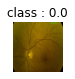

torch.Size([3, 512, 512])
--- 테스트 ---
tensor([1.3246e-10], device='cuda:0')


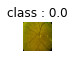

torch.Size([3, 512, 512])
--- 테스트 ---
tensor([1.6741e-23], device='cuda:0')


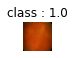

torch.Size([3, 512, 512])
--- 테스트 ---
tensor([0.6248], device='cuda:0')


In [27]:
# test 데이터
pltsize=1
plt.figure(figsize=(20*pltsize,2*pltsize))

with torch.no_grad():
    for image,label in test_loader:
        plt.subplot(2,10,1)
        plt.axis('off')
        plt.imshow(np.transpose(image[0].detach().numpy(),(1,2,0)))
        plt.title('class : '+str(label[0].item()))
        plt.show()
        #print("bias : ",model.bias)
        
        print(image[1].size())
        image = image[0].unsqueeze(0).to(DEVICE)
        output = model(image)
        print("--- 테스트 ---")
        print(output)
        

In [28]:
print(model.weighted)


Parameter containing:
tensor([[0.9997, 0.9997, 0.9998,  ..., 0.9997, 0.9999, 0.9999],
        [0.9999, 0.9999, 1.0000,  ..., 0.9998, 0.9999, 0.9999],
        [1.0001, 1.0000, 1.0000,  ..., 1.0000, 0.9999, 0.9999],
        ...,
        [0.9995, 1.0000, 1.0001,  ..., 0.9998, 0.9998, 0.9998],
        [0.9989, 0.9996, 1.0000,  ..., 0.9998, 0.9997, 0.9999],
        [0.9989, 0.9989, 0.9998,  ..., 0.9997, 0.9997, 0.9999]],
       device='cuda:0', requires_grad=True)


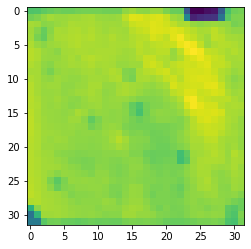

In [29]:
weight_img=model.weighted.cpu().detach() 
plt.imshow(np.absolute(weight_img.numpy()))# 배치에서 10개만 추출

In [25]:
torch.sigmoid(torch.zeros((32, 32), requires_grad=True))

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       grad_fn=<SigmoidBackward>)

In [41]:
#torch dot product
torch.sum(torch.tensor([[2,2],[2,2]])*torch.tensor([[2,2],[2,2]]))

tensor(16)

In [17]:
#내가 원하는 weight도 같이 학습 시키려면 어떻게 해야하나?
#nn 에서 모델을 불러서 사용
#또는 optimizer에 정의.
x = torch.rand(32,32)
x

tensor([[0.8445, 0.4123, 0.3736,  ..., 0.3816, 0.4473, 0.2003],
        [0.5318, 0.2462, 0.5090,  ..., 0.3537, 0.0742, 0.0706],
        [0.9332, 0.5856, 0.0090,  ..., 0.2976, 0.2660, 0.4282],
        ...,
        [0.7690, 0.5879, 0.1409,  ..., 0.7727, 0.0590, 0.7549],
        [0.2052, 0.9580, 0.5343,  ..., 0.1544, 0.5384, 0.6332],
        [0.0800, 0.8906, 0.5098,  ..., 0.6979, 0.6349, 0.5948]])

참조,

https://sparrow.dev/pytorch-numpy-conversion/ :넘파이, torch 변환

https://wikidocs.net/57805 : 로지스틱 회귀 개념

https://gaussian37.github.io/dl-pytorch-snippets/#opencv%EB%A1%9C-%EC%9E%85%EB%A0%A5-%EB%B0%9B%EC%9D%80-%EC%9D%B4%EB%AF%B8%EC%A7%80-torch-%ED%98%95%ED%83%9C%EB%A1%9C-%EB%B3%80%EA%B2%BD-1 : opencv torch 변환

https://discuss.pytorch.org/t/how-to-make-a-tensor-part-of-model-parameters/51037/7 : 학습가능한 변수

In [6]:
class Weighted():
    def __init__(self, **kwargs):
        self.output_dim = 1
        print("init")
        super(Weighted, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build')

    def call(self, x):
        print('call')

    def compute_output_shape(self, input_shape):
        print("compute")
        
        
Weighted()("3")

init


TypeError: 'Weighted' object is not callable